In [1]:
# Only flag for single warning if there are repeats
import warnings
warnings.filterwarnings(action='once')

from panel_segmentation import utils
import glob
import matplotlib.pyplot as plt
from PIL import Image
from ultralytics import YOLO
import os
from shapely.geometry import Polygon
import geopandas

# Run a system through the Hail Detection Pipeline

First, let's pull some example images down from the hail data examples folder. This data is taken from a November 2023 scan of Austin, TX.

In [2]:
example_images = glob.glob("./panel_segmentation/examples/austin_hail_data_examples/*.png")
print(example_images)

['./panel_segmentation/examples/austin_hail_data_examples\\30.1478_-97.74105.png', './panel_segmentation/examples/austin_hail_data_examples\\30.1478_-97.7424.png', './panel_segmentation/examples/austin_hail_data_examples\\30.1486_-97.8116.png', './panel_segmentation/examples/austin_hail_data_examples\\30.1488_-97.8019.png', './panel_segmentation/examples/austin_hail_data_examples\\30.2188_-97.8258.png', './panel_segmentation/examples/austin_hail_data_examples\\30.2738_-97.8217.png', './panel_segmentation/examples/austin_hail_data_examples\\30.487_-97.6921.png', './panel_segmentation/examples/austin_hail_data_examples\\30.487_-97.7222.png', './panel_segmentation/examples/austin_hail_data_examples\\30.495_-97.7366.png']


Let's visualize some of the images beforehand. Several of these images contain PV installations that have visible hail damage.

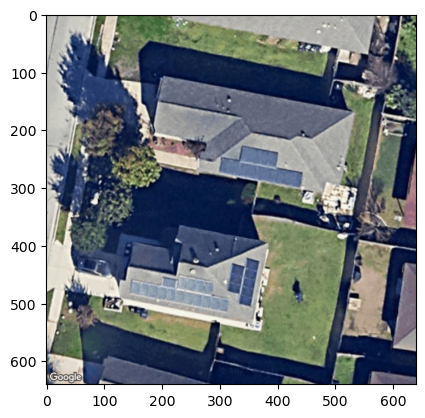

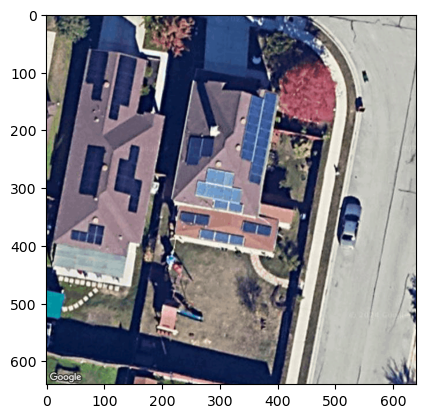

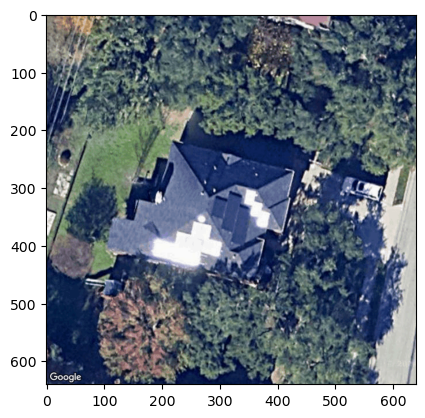

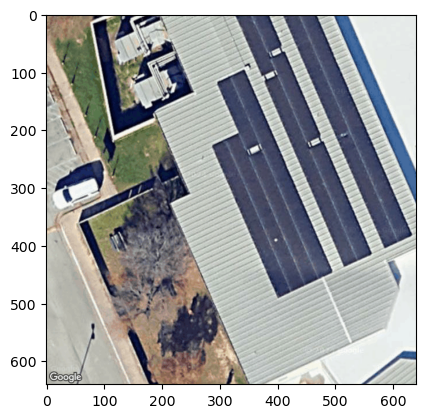

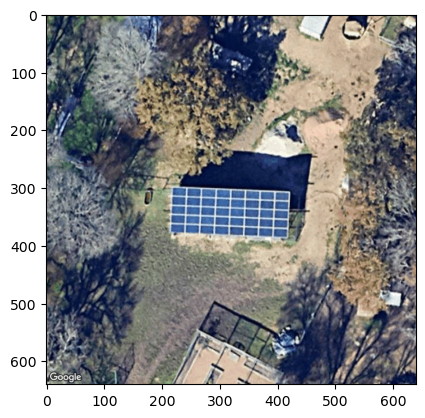

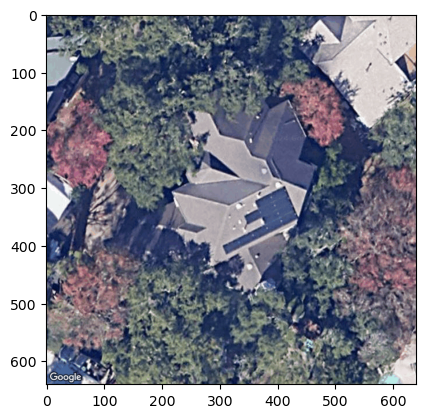

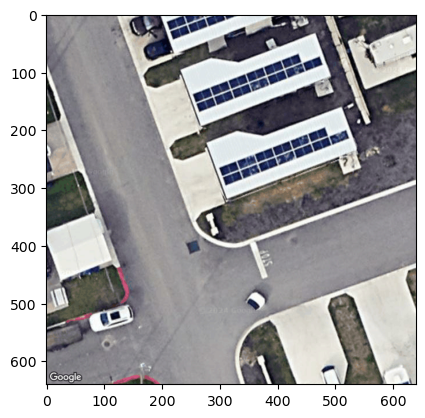

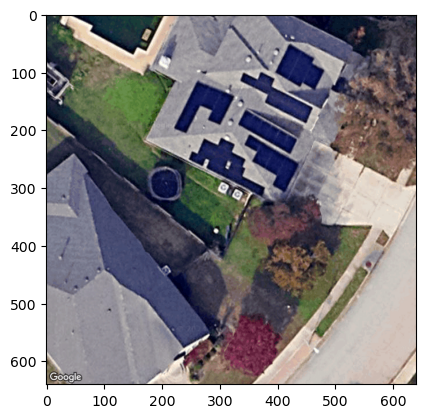

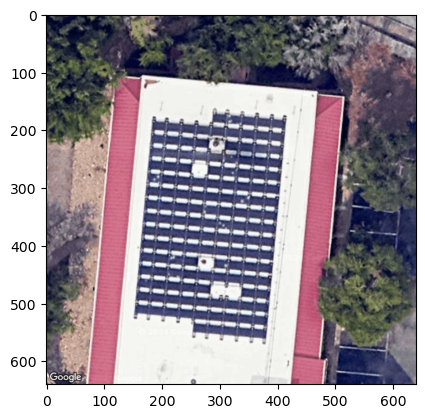

In [3]:
for image_file in example_images:
    img = Image.open(image_file)
    plt.imshow(img)
    plt.show()
    plt.close()

Let's load in the YOLOv11 hail model via Ultralytics.

In [4]:
hail_model_path = "./panel_segmentation/models/hail_model.pt"
hail_model = YOLO(hail_model_path)

Next, lets run these images through the hail detection algorithms, and visualize our mask outputs.


0: 640x640 3 panels, 134.1ms
1: 640x640 11 panels, 134.1ms
2: 640x640 2 panels, 134.1ms
3: 640x640 9 panels, 2 damages, 134.1ms
4: 640x640 1 panel, 134.1ms
5: 640x640 1 panel, 134.1ms
6: 640x640 3 panels, 7 damages, 134.1ms
7: 640x640 6 panels, 134.1ms
8: 640x640 2 panels, 3 damages, 134.1ms
Speed: 5.4ms preprocess, 134.1ms inference, 31.2ms postprocess per image at shape (1, 3, 640, 640)


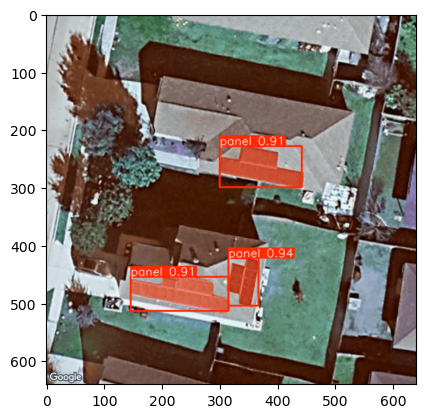

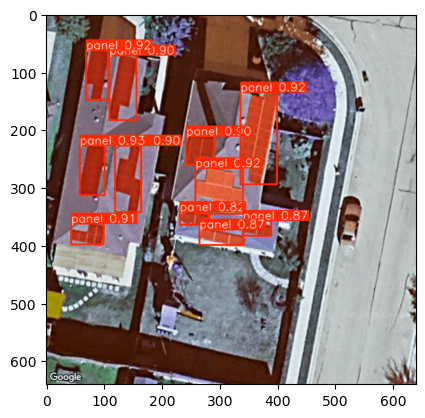

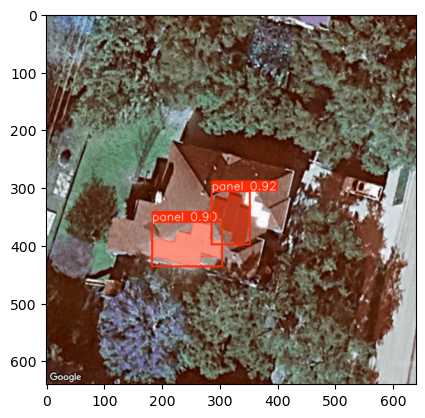

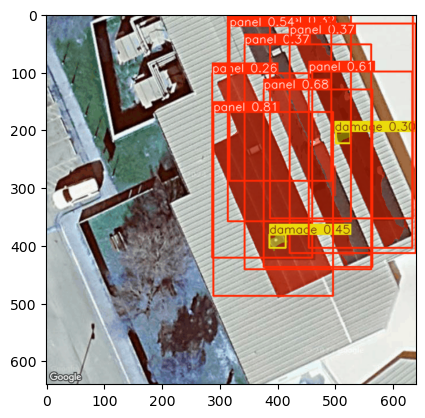

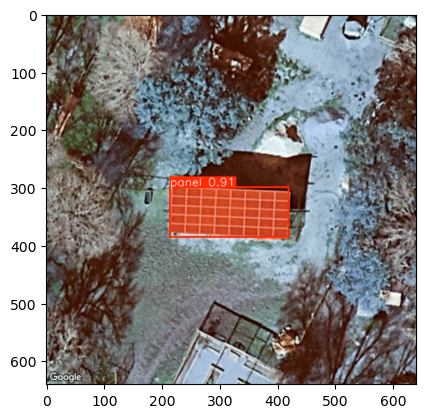

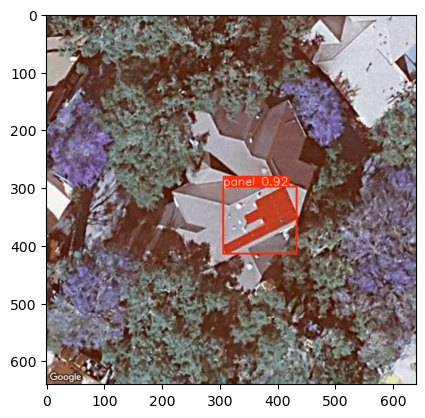

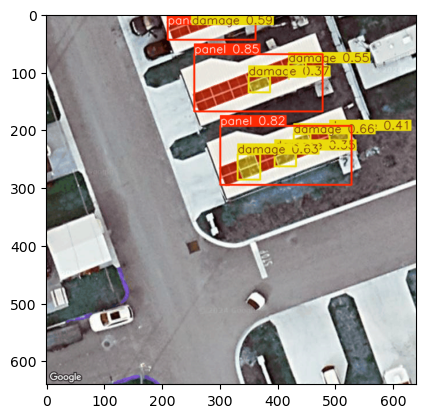

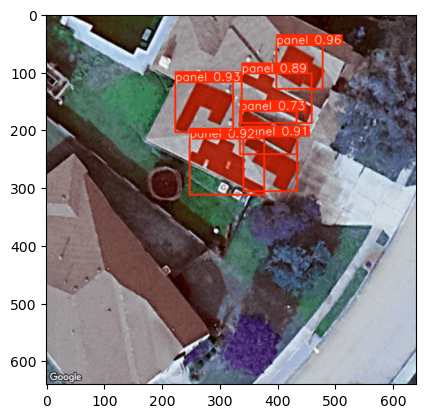

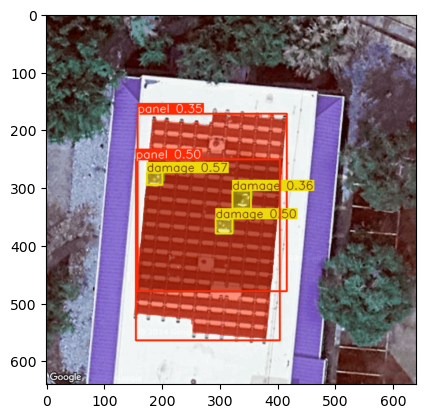

In [5]:
# Run inference on all of the example images
results = hail_model(example_images, overlap_mask=False)

# Visualize the model inference outputs
for result in results:
    plot = result.plot()
    plt.imshow(plot)
    plt.show()
    plt.close()

We can convert our mask outputs to polygons, and get the associated area for each polygon.

In [8]:
for result in results:
    masks = result.masks
    file_name = os.path.basename(result.path)
    img_center_lat, img_center_lon = float(file_name.split("_")[0]), float(file_name.split("_")[-1].replace(".png", ""))
    image_x_pixels, image_y_pixels = result.orig_shape
    for index in range(len(masks)):
        segmentation_mask = masks[index].data.cpu()[0].numpy()
        # Convert the mask to a polygon
        polygon_lat_lon_coords = utils.convertMaskToLatLonPolygon(segmentation_mask, 
                                                                  img_center_lat, 
                                                                  img_center_lon,
                                                                  image_x_pixels, 
                                                                  image_y_pixels,
                                                                  zoom_level=21)
        # Convert to a geoJSON
        shapely_poly = Polygon(polygon_lat_lon_coords)
        geojson_poly = geopandas.GeoSeries(shapely_poly).to_json()
        shapely_poly
        

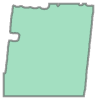

In [9]:
shapely_poly